In [40]:
import projection
import numpy as np
import plot
from plot import plot_mass
import matplotlib.pyplot as plt
import read_chroma
import mass_spec
from pyteomics import mzml, auxiliary
from skimage.feature import peak_local_max
import time
import peak_detection
import benchmark
import matching
from matchms.importing import load_from_mgf
import utils
import importlib
import chromatof
import pybaselines
from scipy import ndimage
from skimage.restoration import estimate_sigma
from scipy import ndimage as ndi

from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from scipy.signal import savgol_filter
import skimage

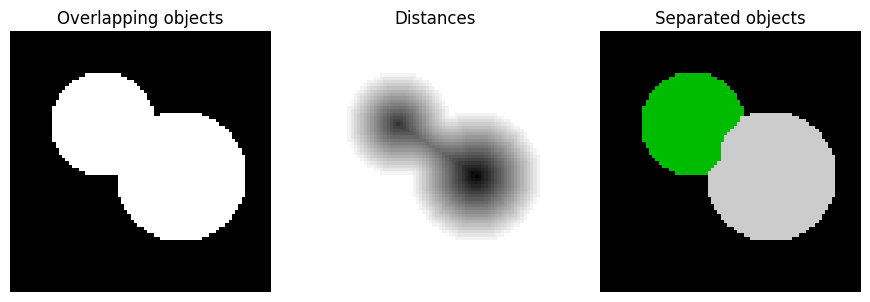

In [41]:
# Generate an initial image with two overlapping circles
x, y = np.indices((80, 80))
x1, y1, x2, y2 = 28, 28, 44, 52
r1, r2 = 16, 20
mask_circle1 = (x - x1)**2 + (y - y1)**2 < r1**2
mask_circle2 = (x - x2)**2 + (y - y2)**2 < r2**2
image = np.logical_or(mask_circle1, mask_circle2)

# Now we want to separate the two objects in image
# Generate the markers as local maxima of the distance to the background
distance = ndi.distance_transform_edt(image)
coords = peak_local_max(distance, footprint=np.ones((3, 3)), labels=image)
mask = np.zeros(distance.shape, dtype=bool)
mask[tuple(coords.T)] = True
markers, _ = ndi.label(mask)
labels = watershed(-distance, markers, mask=image)

fig, axes = plt.subplots(ncols=3, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Overlapping objects')
ax[1].imshow(-distance, cmap=plt.cm.gray)
ax[1].set_title('Distances')
ax[2].imshow(labels, cmap=plt.cm.nipy_spectral)
ax[2].set_title('Separated objects')

for a in ax:
    a.set_axis_off()

fig.tight_layout()
plt.show()

In [42]:
importlib.reload(read_chroma)
filename = "data/G0-1-250123.cdf"
filename = "F:/Bureau/032023-data-Tenax-VOC-COVID/801850-A-C-01-157-split10.cdf"
mod_time = 1.25
chromato_obj = read_chroma.read_chroma(filename, mod_time)
chromato,time_rn,spectra_obj = chromato_obj

In [43]:
filename = "data/G0-1-250123.cdf"
filename = "F:/Bureau/032023-data-Tenax-VOC-COVID/801850-A-C-01-157-split10.cdf"

mod_time = 1.25
chromato_obj = read_chroma.read_chroma(filename, mod_time)
chromato,time_rn,spectra_obj = chromato_obj
full_spectra = mass_spec.read_full_spectra_centroid(spectra_obj=spectra_obj)

--- 331.1269392967224 seconds --- to compute full spectra centroid


In [44]:
tmp = np.empty_like(chromato)
for i in range (tmp.shape[1]):
    #tmp[:,i] = ndi.gaussian_filter(chromato[:,i] - pybaselines.whittaker.asls(chromato[:,i], lam=100.0, p=0.05, max_iter=40)[0], 1)
    tmp[:,i] = savgol_filter(chromato[:,i] - pybaselines.whittaker.asls(chromato[:,i], lam=100.0, p=0.05, max_iter=40)[0], 5, 2, mode='nearest')
tmp[tmp < .0] = .0

In [45]:
spectra, debuts, fins = full_spectra
chromato_cube = read_chroma.full_spectra_to_chromato_cube(full_spectra=full_spectra, spectra_obj=spectra_obj)

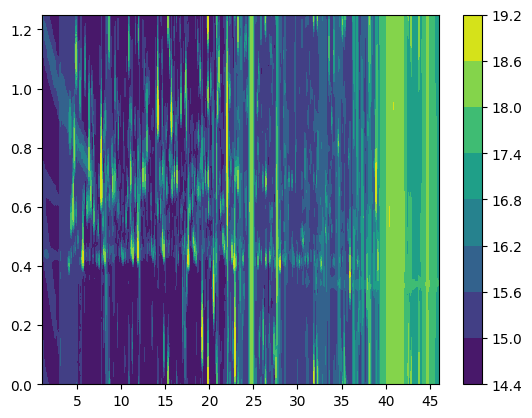

In [73]:
plot.visualizer((chromato, time_rn))

In [47]:
sigma_hat = estimate_sigma(tmp, channel_axis=None)
np.min(tmp), sigma_hat, np.max(tmp)

(0.0, 5603.6545346047205, 166269934.0647264)

In [48]:
u = peak_detection.plm((tmp,time_rn), mod_time, seuil= 5 * sigma_hat * 100 / np.max(tmp))
len(u)

1245

In [49]:
u_int = np.array([chromato[cd[0], cd[1]] for cd in u])

In [50]:
importlib.reload(projection)

<module 'projection' from 'c:\\Users\\Stan\\pic\\projection.py'>

In [51]:
u_in_chromato = projection.matrix_to_chromato(u, time_rn, 1.25, chromato.shape)

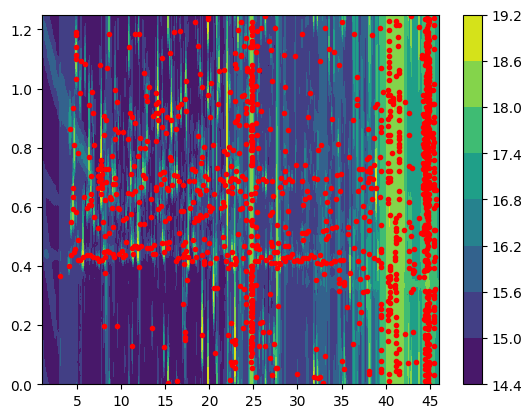

In [74]:
importlib.reload(plot)
plot.visualizer((chromato, time_rn), points=u_in_chromato)

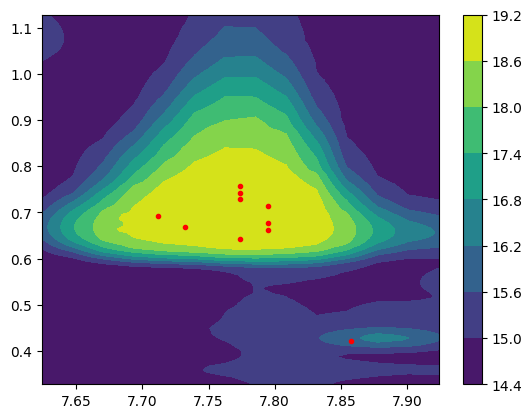

In [52]:
importlib.reload(plot)
plot.visualizer((chromato, time_rn), points=u_in_chromato, rt1=u_in_chromato[3][0], rt2=u_in_chromato[3][1], rt1_window = 0.15, rt2_window= 0.4)

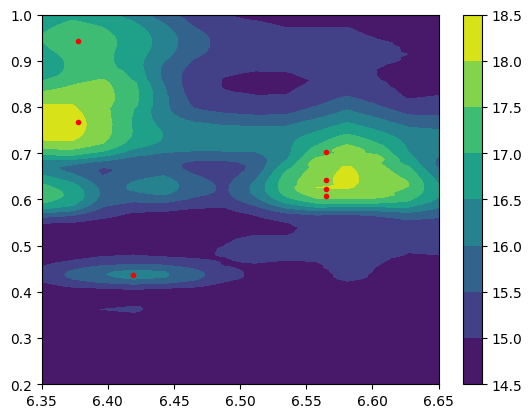

In [89]:
importlib.reload(plot)
plot.visualizer((chromato, time_rn), points=u_in_chromato, rt1=6.5, rt2=0.6, rt1_window = 0.15, rt2_window= 0.4)

In [53]:
chromato_cp = chromato.copy()

In [54]:
print(np.max(chromato_cp[1150:1160, 10:20]))

45280147.269436434


In [55]:
print(chromato_cp[1154, 15])

17740425.45534697


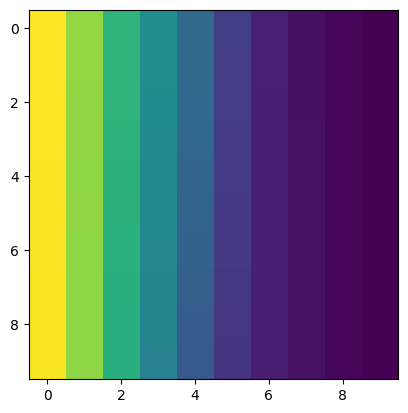

In [56]:
plt.imshow(np.transpose(chromato_cp[1150:1160, 10:20]))

# Contour de tous les blobs

In [57]:
def peak_pool(chromato, coordinate, threshold=0.25, plot_labels=False):
    mask = np.zeros(chromato.shape, dtype=bool)
    mask[tuple(u.T)] = True
    markers, _ = ndi.label(mask)
    peak_apex_int = chromato[coordinate[0]][coordinate[1]]
    img = np.where(chromato < threshold * peak_apex_int, 0, 1)
    labels = watershed(-chromato, markers, mask=img)
    if (plot_labels):
        plot.visualizer((labels, time_rn))
    coordinate_label = labels[coordinate[0]][coordinate[1]]
    blob = np.where(labels != coordinate_label, 0, 1)
    return blob

In [58]:
def get_all_area(chromato, coordinates, threshold=0.25):
    blobs = []
    for coordinate in coordinates:
        blobs.append(peak_pool(chromato, coordinate, threshold=threshold))
    return np.array(blobs)

In [59]:
def get_contour(blob):
    contour=skimage.segmentation.expand_labels(blob, distance=1) - blob
    contour_pts = np.argwhere(contour != 0)
    return projection.matrix_to_chromato(contour_pts, time_rn, 1.25, chromato.shape)

In [60]:
def get_all_contour(blobs):
    all_contour=[]
    for blob in blobs:
        blob_contour = get_contour(blob)
        for contour in blob_contour:
            all_contour.append(contour)
    return np.unique(all_contour, axis=-0)

In [61]:
all_area = get_all_area(tmp, u, threshold=0.1)

In [62]:
all_contour = get_all_contour(all_area)

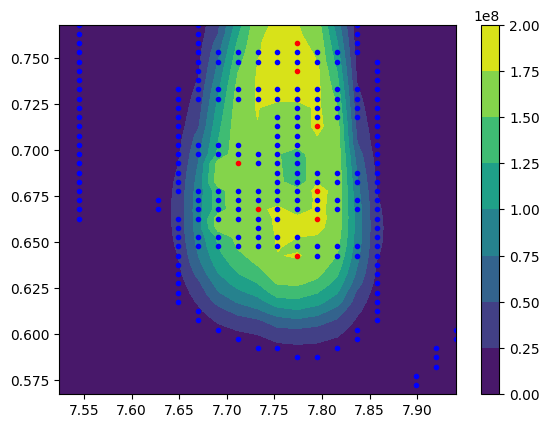

In [87]:
importlib.reload(plot)
plot.visualizer((chromato, time_rn), log_chromato=False, contour=all_contour, points=u_in_chromato, center_pt=u[20], center_pt_window_1=10, center_pt_window_2=20)

# Contour d'un blob

In [64]:
point = u[3]
blob = peak_pool(tmp, point, threshold=0.1)

In [65]:
contour=skimage.segmentation.expand_labels(blob, distance=1) - blob

In [66]:
contour_pts = np.argwhere(contour != 0)

In [67]:
contour_pts_in_chromato = projection.matrix_to_chromato(contour_pts, time_rn, 1.25, chromato.shape)

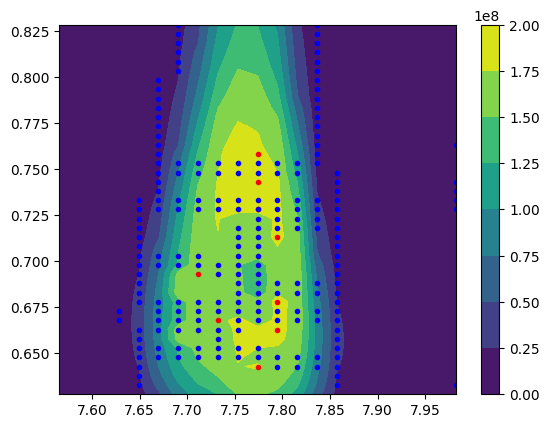

In [81]:
importlib.reload(plot)
plot.visualizer((chromato, time_rn), log_chromato=False, contour=all_contour, points=u_in_chromato, center_pt=point, center_pt_window_1 = 10, center_pt_window_2 = 20)

# Integration with ms similarity

In [69]:
from sklearn.cluster import DBSCAN

In [70]:
def similarity_cluestering(coordinates, ref_point, similarity_threshold=0.01):
    mass_values_list = []
    intensity_values_list = []
    ref_point_index = 0
    for i, coordinate in enumerate(coordinates):
        if (coordinate[0]==ref_point[0] and coordinate[1]==ref_point[1]):
            ref_point_index = i
        mass_values, int_values = mass_spec.read_spectrum(chromato, coordinate, spectra)
        mass_values_list.append(mass_values)
        intensity_values_list.append(int_values)
    intensity_values_list = np.array(intensity_values_list)
    clustering = DBSCAN(eps=similarity_threshold, min_samples=1, metric='cosine').fit(intensity_values_list)
    ref_label = (clustering.labels_[ref_point_index])
    print(len(coordinates))
    print(len(np.unique(clustering.labels_)))
    res = []
    for i, coordinate in enumerate(coordinates):
        if (clustering.labels_[i] == ref_label):
            res.append(coordinate)
    return np.array(res)


In [71]:
def peak_pool_2(chromato, coordinate, threshold=0.25, plot_labels=False, similarity_threshold=0.01):
    mask = np.zeros(chromato.shape, dtype=bool)
    mask[tuple(u.T)] = True
    markers, _ = ndi.label(mask)
    peak_apex_int = chromato[coordinate[0]][coordinate[1]]
    img = np.where(chromato < threshold * peak_apex_int, 0, 1)
    labels = watershed(-chromato, markers, mask=img)
    if (plot_labels):
        plot.visualizer((labels, time_rn), log_chromato=False)
    coordinate_label = labels[coordinate[0]][coordinate[1]]
    blob = np.where(labels != coordinate_label, 0, 1)
    cds = []
    for cd in np.argwhere(blob == 1):
        cds.append([cd[0], cd[1]])
    cds = np.array(cds)
    cds = similarity_cluestering(cds, similarity_threshold=similarity_threshold, ref_point=coordinate)
    res = np.zeros_like(chromato)
    for cd in cds:
        res[cd[0], cd[1]] = 1
    return res

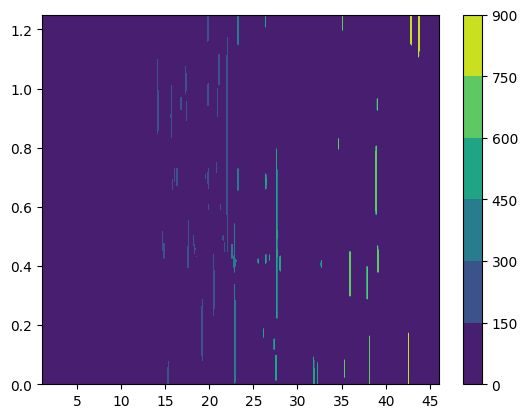

11
1


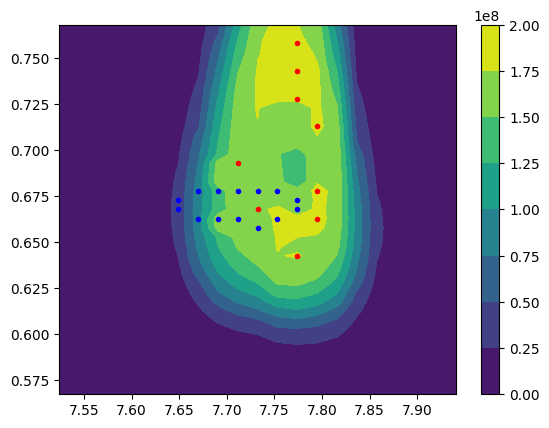

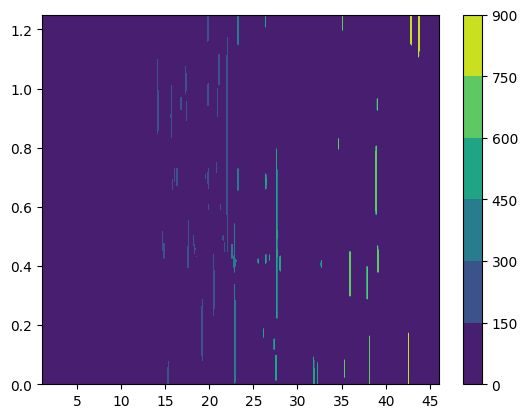

11
1


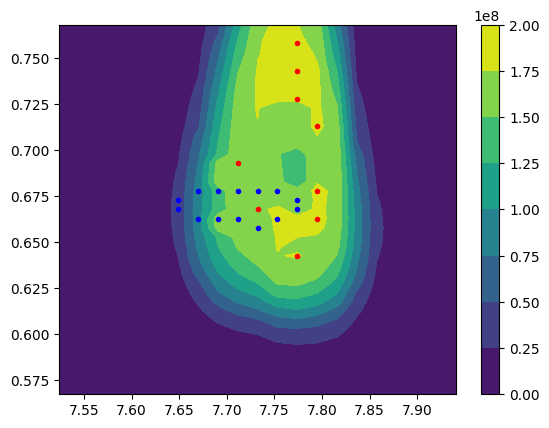

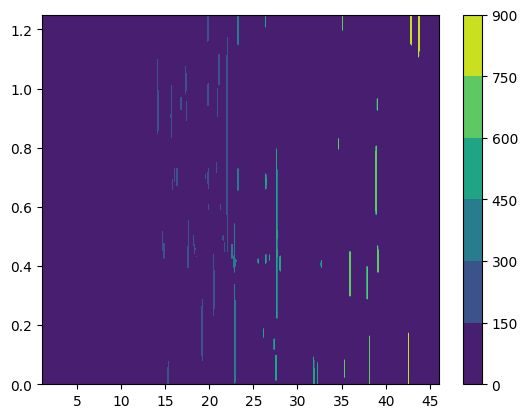

11
1


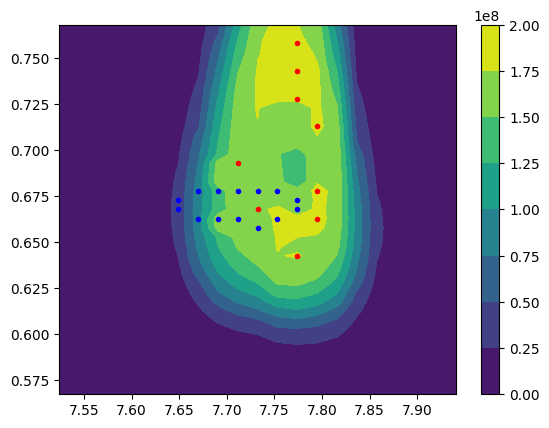

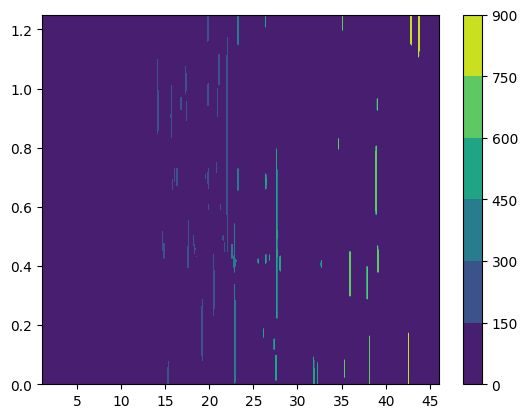

11
2


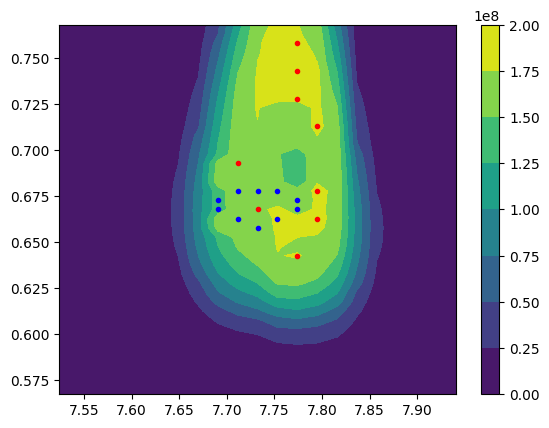

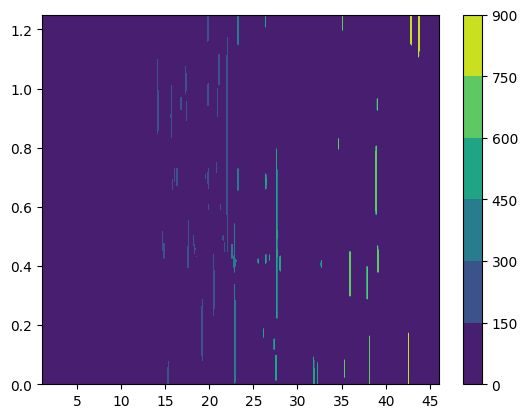

11
6


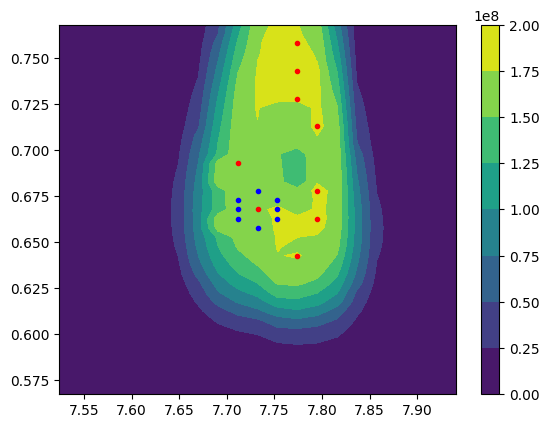

In [83]:
point = u[20]
for similarity_threshold in [50, 0.9, 0.1, 0.01, 0.001]:
    blob = peak_pool_2(tmp, point, threshold=0.3, plot_labels=True, similarity_threshold=similarity_threshold)
    blob_contour = get_contour(blob)
    plot.visualizer((chromato, time_rn), log_chromato=False, contour=blob_contour, points=u_in_chromato, center_pt=point, center_pt_window_1 = 10, center_pt_window_2 = 20)